In [ ]:
# 1. Import dataset
# 2. Convert to supervised-learning dataset
# 3. Train RNN
# 4. Predict
# 5. Evaluate

In [24]:
# 1. Import dataset

import matplotlib.pyplot as plt
import pandas as pd

df = pd.read_csv('../data/hdb-resale-price-index/housing-and-development-board-resale-price-index-1q2009-100-quarterly.csv',
                 parse_dates=True, index_col=0)


df.rename(columns={'index': 'price'}, inplace=True)
df.head()

,price
quarter,
1990-01-01,24.3
1990-04-01,24.4
1990-07-01,25.0
1990-10-01,24.7
1991-01-01,24.9


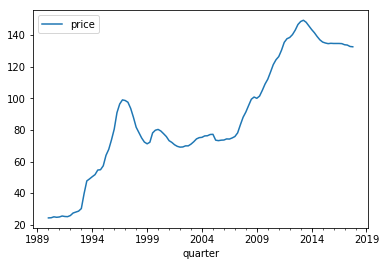

In [102]:
import matplotlib.pyplot as plt
df.plot()
plt.show()

In [40]:
# Signature: series_s.shift(periods=1, freq=None, axis=0)
# Docstring: Shift index by desired number of periods with an optional time freq

series = pd.DataFrame(df.price.values)

print(series.values.flatten()) # flatten to print nicely

# shift left
print()
print(series.shift(-1).values.flatten())

# shift right
print()
print(series.shift(1).values.flatten())

[ 24.3  24.4  25.   24.7  24.9  25.5  25.2  25.1  25.8  27.4  28.   28.6
  30.2  39.6  47.7  49.   50.4  51.7  54.6  54.8  57.3  63.9  67.7  73.7
  80.5  90.9  96.4  99.   98.6  97.5  93.6  88.   81.7  78.3  74.9  72.3
  71.2  72.2  78.1  79.8  80.3  79.3  77.6  75.8  73.2  72.1  70.6  69.6
  69.1  69.2  69.9  69.9  71.   72.5  74.3  75.1  75.3  76.2  76.3  77.1
  77.2  73.5  73.2  73.5  73.6  74.3  74.2  74.9  75.8  78.1  83.2  88.
  91.3  95.4  99.4 100.8 100.  101.4 105.  109.  112.1 116.6 121.3 124.4
 126.4 130.4 135.4 137.7 138.5 140.3 143.1 146.7 148.6 149.4 148.1 145.8
 143.5 141.5 139.1 137.  135.6 135.  134.6 134.8 134.7 134.7 134.7 134.6
 133.9 133.7 132.8 132.6]

[ 24.4  25.   24.7  24.9  25.5  25.2  25.1  25.8  27.4  28.   28.6  30.2
  39.6  47.7  49.   50.4  51.7  54.6  54.8  57.3  63.9  67.7  73.7  80.5
  90.9  96.4  99.   98.6  97.5  93.6  88.   81.7  78.3  74.9  72.3  71.2
  72.2  78.1  79.8  80.3  79.3  77.6  75.8  73.2  72.1  70.6  69.6  69.1
  69.2  69.9  69.9  71.  

In [66]:
# 2. Convert to supervised-learning dataset

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# window
window_size = 50

series = pd.DataFrame(df.price.values)
series_s = series.copy()

# Stack pandas dataframes:
# 24.3  24.4  25.0  24.7  24.9  25.5  25.2  25.1  25.8  27.4 ...
# 24.4  25.0  24.7  24.9  25.5  25.2  25.1  25.8  27.4 ...
# 25.0  24.7  24.9  25.5  25.2  25.1  25.8  27.4 ...
# ...
# 50 times

for i in range(window_size):
    series = pd.concat([series, series_s.shift(-(i+1))], axis=1)

# drop last few rows
series.dropna(inplace=True)
print(series.shape)

(62, 51)


In [68]:
# scale (Note: don't need to split beforehand for time series)
scaler = StandardScaler()
series_scaled = scaler.fit_transform(series)

# train test split (Note: shuffle is okay)
train, test = train_test_split(series_scaled, random_state=42)

print(train)
print('training set shape', train.shape)
print('test set shape', test.shape)

[[-1.72415902 -1.79312974 -1.85021855 ... -1.28969535 -1.29842302
  -1.29497737]
 [-0.51965096 -0.43584397 -0.47530772 ... -1.13909011 -1.18793789
  -1.21127075]
 [ 0.48856689  0.50100312  0.48666061 ...  0.92488618  0.90437424
   0.87441912]
 ...
 [ 1.57262413  1.52467993  1.34539332 ... -0.25941862 -0.24881429
  -0.16145026]
 [ 0.29227668  0.3136337   0.35526981 ...  1.00703449  0.93199552
   0.88488245]
 [ 0.65809024  0.71579245  0.72128703 ...  0.95226895  1.00450139
   1.0069546 ]]
training set shape (46, 51)
test set shape (16, 51)


In [69]:
train.shape

(46, 51)

In [71]:
# select first 50 columns => X
# select last column => y (next value we want to predict/forecast)
train_X = train[:, :-1]
train_y = train[:, -1]

print(train_X.shape)
print(train_y.shape)

(46, 50)
(46,)


In [73]:
test_X = test[:, :-1]
test_y = test[:, -1]

print(test_X.shape)
print(test_y.shape)

(16, 50)
(16,)


In [75]:
# RNN requires: num_samples, num_features (50), num_time_steps (1)
train_X = train_X.reshape(train_X.shape[0], train_X.shape[1], 1)
test_X = test_X.reshape(test_X.shape[0], test_X.shape[1], 1)

print('training set shape', train_X.shape)
print('test set shape', test_X.shape)

training set shape (46, 50, 1)
test set shape (16, 50, 1)


In [76]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Activation

model = Sequential()
model.add(LSTM(input_shape=(50, 1), units=50, return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(256))
model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation("linear"))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (None, 50, 50)            10400     
_________________________________________________________________
dropout_5 (Dropout)          (None, 50, 50)            0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 256)               314368    
_________________________________________________________________
dropout_6 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 257       
_________________________________________________________________
activation_3 (Activation)    (None, 1)                 0         
Total params: 325,025
Trainable params: 325,025
Non-trainable params: 0
_________________________________________________________________


In [81]:
from keras.callbacks import TensorBoard, EarlyStopping
import time

model.compile(loss="mse", optimizer="adam")

tensorboard = TensorBoard(log_dir='./logs/timeseries/%d' % time.time())
earlystopping = EarlyStopping(patience=2)

model.fit(train_X, train_y,
          batch_size=8,
          epochs=10,
          validation_data=(test_X, test_y),
          callbacks=[tensorboard, earlystopping])

Train on 46 samples, validate on 16 samples
Epoch 1/10
46/46 [==============================] - 6s 141ms/step - loss: 0.0792 - val_loss: 0.0736
Epoch 2/10
46/46 [==============================] - 1s 28ms/step - loss: 0.0347 - val_loss: 0.0552
Epoch 3/10
46/46 [==============================] - 1s 29ms/step - loss: 0.0325 - val_loss: 0.0285
Epoch 4/10
46/46 [==============================] - 1s 28ms/step - loss: 0.0304 - val_loss: 0.0327
Epoch 5/10
46/46 [==============================] - 1s 29ms/step - loss: 0.0552 - val_loss: 0.0615


In [103]:
# predict the future resale price
import numpy as np
last_input = test_X[-1]
future_price = model.predict(np.expand_dims(last_input, 0))

print(future_price)

# inverse transform manually
# standard_scaler subtracts mean and divides by stddev
future_price = (future_price * np.sqrt(scaler.var_[-1])) + scaler.mean_[-1]
print(future_price)

[[0.5485377]]
[[125.35647]]


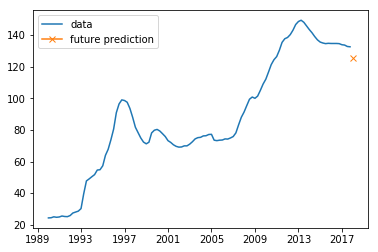

In [108]:
fig, ax = plt.subplots()
ax.plot(df, label='data')
ax.plot(pd.to_datetime('2018-01-01'), future_price, marker='x', label='future prediction')
ax.legend()

plt.show()

In [109]:
df.index

DatetimeIndex(['1990-01-01', '1990-04-01', '1990-07-01', '1990-10-01',
               '1991-01-01', '1991-04-01', '1991-07-01', '1991-10-01',
               '1992-01-01', '1992-04-01',
               ...
               '2015-07-01', '2015-10-01', '2016-01-01', '2016-04-01',
               '2016-07-01', '2016-10-01', '2017-01-01', '2017-04-01',
               '2017-07-01', '2017-10-01'],
              dtype='datetime64[ns]', name='quarter', length=112, freq=None)